## Enviroment:

Open AI gym [CartPole v0](https://github.com/openai/gym/wiki/CartPole-v0)

### Observation

Type: Box(4)

| Num  | Observation          | Min      | Max     |
| :--- | :------------------- | :------- | :------ |
| 0    | Cart Position        | -2.4     | 2.4     |
| 1    | Cart Velocity        | -Inf     | Inf     |
| 2    | Pole Angle           | ~ -41.8° | ~ 41.8° |
| 3    | Pole Velocity At Tip | -Inf     | Inf     |

### Actions

Type: Discrete(2)

| Num  | Action                 |
| :--- | :--------------------- |
| 0    | Push cart to the left  |
| 1    | Push cart to the right |

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

### Reward

Reward is 1 for every step taken, including the termination step

### Starting State

All observations are assigned a uniform random value between ±0.05

### Episode Termination

1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200

### Solved Requirements

Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials

## 1. gym enviroment setup

In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt

env = gym.make("CartPole-v0")
env.reset()

array([-0.03753636, -0.01905513,  0.03099227, -0.04468279])

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import losses,optimizers,metrics
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
from tqdm import tqdm

In [0]:
ACTION_SPACE_SIZE = env.action_space.n
REPLAY_MEMORY_SIZE = 50_000
MIN_REPLAY_MEMORY_SIZE = 1_000
MINIBATCH_SIZE = 64
UPDATE_TARGET_EVERY = 5
DISCOUNT = 0.99
EPISODES =1000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.001

ep_rewards = []

AGGREGATE_STATS_EVERY = 50
MIN_EPSILON = 0.001

### Plot epsilon decay 

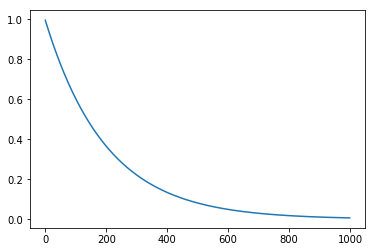

In [4]:
recorder = {"epsode":[],"epsilon":[]}

for epsode in range(EPISODES):
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
    
    recorder["epsode"].append(epsode)
    recorder["epsilon"].append(epsilon)

plt.plot(recorder["epsode"], recorder["epsilon"])

## 2.  create_model

In [0]:
def create_model():
  model = models.Sequential()
  
#   model.add(Flatten(input_shape=(2,)))
  model.add(Dense(16 ,input_shape=(env.observation_space.shape)))
  model.add(Activation('relu'))
  model.add(Dense(16))
  model.add(Activation('relu'))
  model.add(Dense(16))
  model.add(Activation('relu'))
  model.add(Dense(ACTION_SPACE_SIZE))
  model.add(Activation('linear'))
  
  print(model.summary())
  
  model.compile(loss = 'mse', optimizer=Adam(lr=0.001),metrics=['accuracy'])
  
  return model


## 3. Agent Class

In [0]:
class DQNAgent:

  def __init__(self):
    
    # Replay memory
    self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
    
    # Prediction Network (the main Model)
    self.model_prediction = create_model()
    
    # Target Network
    self.model_target = create_model()
    self.model_target.set_weights(self.model_prediction.get_weights())
    
   
    
    # Used to count when to update target network with prediction network's weights
    self.target_update_counter = 0
    
    
  
  # Adds step's data to a memory replay array
  # (current_state, action, reward, next_state, done)
  def update_replay_memory(self, transition):
    self.replay_memory.append(transition)
  
  
  
  # Queries prediction network for Q values given current observation space (environment state)
  def get_qs(self, state):
    return self.model_prediction.predict(np.array(state).reshape(-1, *state.shape))[0]
  
  def train(self, terminal_state, step):
    
    if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
      return
    
    minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
    
    # Get current states from minibatch, then query NN model_prediction for current Q values
    current_states = np.array([transition[0] for transition in minibatch])
    current_qs_list = self.model_prediction.predict(current_states)   
    
    # Get next_states from minibatch, then query NN model_target for target Q values
    # When using target network, query it, otherwise main network should be queried
    next_states = np.array([transition[3] for transition in minibatch])
    next_qs_list = self.model_prediction.predict(next_states)
    
    target_qs_list = self.model_target.predict(next_states)
    
    X = []
    y = []
    
    # Now we need to enumerate our batches
    for index, (current_state, action, reward, next_state, done) in enumerate(minibatch):

        # If not a terminal state, get new q from future states, otherwise set it to 0
        # almost like with Q Learning, but we use just part of equation here
        if not done:
            max_target_a = np.argmax(next_qs_list[index])

#             max_target_q = np.max(target_qs_list[index])
            max_target_q = target_qs_list[index][max_target_a]
            new_q = reward + DISCOUNT * max_target_q
        else:
            new_q = reward

        # Update Q value for given state
        current_qs = current_qs_list[index]
        current_qs[action] = new_q

        # And append to our training data
        X.append(current_state)
        y.append(current_qs)    
    
    # Fit on all samples as one batch, log only on terminal state
    self.model_prediction.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False if terminal_state else None)
    
    # Update target network counter every episode
    if terminal_state:
        self.target_update_counter +=1
    
    # If counter reaches set value, update target network with weights of main network
    if self.target_update_counter > UPDATE_TARGET_EVERY:
      self.model_target.set_weights(self.model_prediction.get_weights())
      self.target_update_counter = 0

In [11]:
agent = DQNAgent()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_8 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_9 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_10 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

## 4. Train the agent

In [0]:
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

In [13]:
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):


    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, ACTION_SPACE_SIZE)

        next_state, reward, done, _ = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

#         if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
#             env.render()

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, next_state, done))
        agent.train(done, step)

        current_state = next_state
        step += 1

    # Append episode reward to a list and log rewards (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['min'].append(min_reward)
        aggr_ep_rewards['max'].append(max_reward)
        
#         agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
#         if min_reward >= MIN_REWARD:
#             agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)


100%|##########| 1000/1000 [45:33<00:00,  3.57s/episodes]


## 5. Plot episodes vs rewards

Text(0, 0.5, 'Rewards')

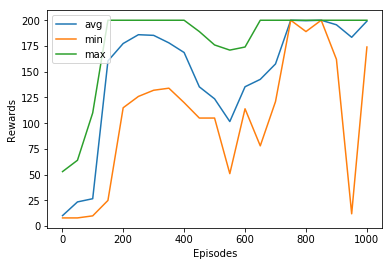

In [14]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

### Save model

In [0]:
agent.model_prediction.save('dqn_1.model')

### Rendering Test

In [0]:
done = False
state = env.reset()
while not done:
    qs_list = agent.get_qs(state)
    action = np.argmax(qs_list())
    next_state, _, done, _ = env.step(action)
    state = next_state
    env.render()

env.close()
    